In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from datetime import timedelta
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import json
import umap
from collections import defaultdict, Counter
from tqdm import tqdm

import seaborn as sns
import numpy as np
sns.set_theme()

from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True, nb_workers=8)

from tqdm import tqdm, tqdm_notebook

tqdm.pandas()


DATA_DIR = 'data/'

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [11]:
from gc import collect

In [2]:
# df_test_users = pl.scan_parquet(f'{DATA_DIR}/test_users.pq')
df_clickstream = pl.scan_parquet(f'{DATA_DIR}/clickstream.pq') # 69_000k
df_cat_features = pl.scan_parquet(f'{DATA_DIR}/cat_features.pq') # 23_000k

#df_text_features = pl.scan_parquet(f'{DATA_DIR}/text_features.pq')

In [3]:
df_event = pl.read_parquet(f'{DATA_DIR}/events.pq')

In [4]:
df_clickstream = df_clickstream.cast(
    {
        "event": pl.UInt8,
        "platform": pl.UInt8,
        "surface": pl.UInt8,
        "node": pl.UInt32,
        "item": pl.UInt32,
        "cookie": pl.UInt32,
    }
)

In [5]:

df_cat_features = df_cat_features.cast(
    {
        "category": pl.UInt8,
        "location": pl.UInt16,
        "node": pl.UInt32,
        "item": pl.UInt32,
    }
)

## Item features

### Basic info

    item -  id объявления [int64]
    location - id локации айтема.  [int64]
    category - id категории товара. [int64]
    clean_params - параметры объявления. В примере [{"attr":859,"value":653982} …]  attr - это id атрибута, value - это id значения атрибута [str]
    node - id группы товара. Сущность , которую необходимо предсказать [int64]

In [6]:
print(df_cat_features.head(3).collect())

shape: (3, 5)
┌──────┬──────────┬──────────┬─────────────────────────────────┬────────┐
│ item ┆ location ┆ category ┆ clean_params                    ┆ node   │
│ ---  ┆ ---      ┆ ---      ┆ ---                             ┆ ---    │
│ i64  ┆ i64      ┆ i64      ┆ str                             ┆ u32    │
╞══════╪══════════╪══════════╪═════════════════════════════════╪════════╡
│ 9    ┆ 8385     ┆ 57       ┆ [{"attr":1157,"value":664427},… ┆ 194747 │
│ 17   ┆ 2707     ┆ 35       ┆ [{"attr":2140,"value":501466},… ┆ 352905 │
│ 144  ┆ 8383     ┆ 8        ┆ [{"attr":802,"value":35791},{"… ┆ 17188  │
└──────┴──────────┴──────────┴─────────────────────────────────┴────────┘


In [7]:
df_cat_features.describe()

statistic,item,location,category,clean_params,node
str,f64,f64,f64,str,f64
"""count""",2.2646691e7,2.264669e7,2.264669e7,"""22646691""",2.2646691e7
"""null_count""",0.0,1.0,1.0,"""0""",0.0
"""mean""",1.4402e7,4349.799844,35.778449,null,173768.117695
"""std""",8.3149e6,2580.792016,15.774887,null,93004.255815
"""min""",0.0,0.0,0.0,"""[]""",1.0
"""25%""",7.201417e6,2348.0,24.0,null,116118.0
"""50%""",1.4402191e7,3707.0,35.0,null,170538.0
"""75%""",2.160266e7,6773.0,51.0,null,229443.0
"""max""",2.8804867e7,9579.0,64.0,"""[{""attr"":979,""value"":795287},{…",424068.0


### Plots

In [138]:
cols = ["item", "category", "location", "node"]
df_cat_features = pl.scan_parquet(f'{DATA_DIR}/cat_features.pq', low_memory=True).select(cols)

In [139]:
df_cat_features.collect().estimated_size('mb')

604.7946758270264

In [140]:
df_sample = df_cat_features.collect().to_pandas()

In [141]:
df_sample.memory_usage() / 10 ** 6

Index         0.000128
item        181.173528
category    181.173528
location    181.173528
node         90.586764
dtype: float64

In [142]:
(df_sample.memory_usage() / 10 ** 6).sum()

634.107476

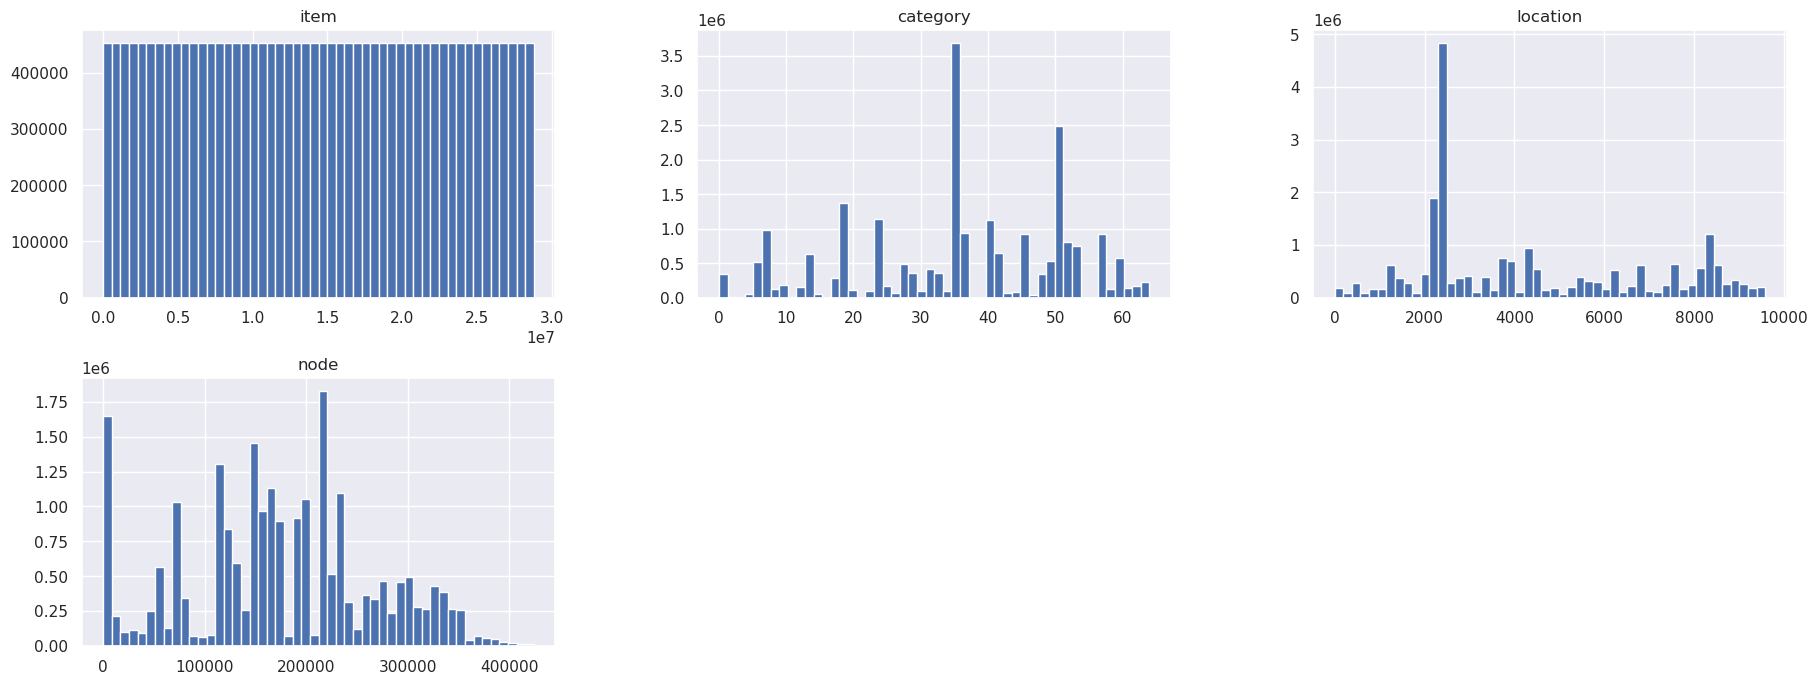

In [8]:
df_sample.hist(figsize=(22, 8), layout=(-1, 3), bins=50);

### Check nodes

- 540 times in dataset for extra popular nodes
- 50% nodes appears <= 3 times

In [152]:
item_counts_per_node = df_sample.groupby('node')['item'].count()

In [156]:
np.quantile(item_counts_per_node, 0.5)

3.0

In [157]:
np.quantile(item_counts_per_node, 0.7)

6.0

In [182]:
np.quantile(item_counts_per_node, 0.95)

68.0

In [163]:
np.quantile(item_counts_per_node, 0.99)

546.0

In [165]:
np.max(item_counts_per_node)

463451

In [169]:
(item_counts_per_node > 540).sum() / item_counts_per_node.shape[0] * 100

1.008632128360679

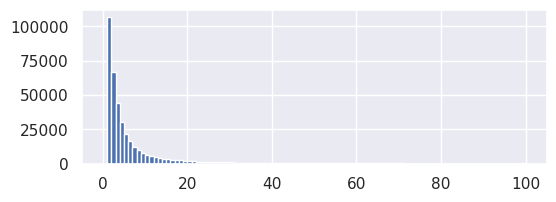

In [173]:
plt.figure(figsize=(6, 2))
plt.hist(item_counts_per_node, bins=100, range=(0, 100));

In [202]:
tmp = df_sample.groupby('node')['category'].apply(lambda x: np.unique(x)[0])

In [206]:
node2cat = tmp.astype(int).to_dict()

In [9]:
del df_sample

### Check node + clean_params

In [2]:
cols = ["clean_params", "node"]
lf = pl.scan_parquet(f'{DATA_DIR}/cat_features.pq').select(cols)
lf.collect().estimated_size('mb')

6016.90335559845

In [3]:
df_sample = lf.head(10_000_000).gather_every(10).collect()
df_sample.estimated_size('mb')

265.24240016937256

In [4]:
df = df_sample.to_pandas()
del df_sample

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   clean_params  1000000 non-null  object
 1   node          1000000 non-null  uint32
dtypes: object(1), uint32(1)
memory usage: 11.4+ MB


In [12]:
attr2values = json.loads(open('models/attr2values_selected.json', 'rb').read())

keys = list(attr2values.keys())
for k in keys:
    attr2values[int(k)] = attr2values[k].copy()
    del attr2values[k]

In [20]:
def increment_attr_count(row):
    for data in json.loads(row['clean_params']):
        attr = data['attr']
        value = data['value']
        if attr in attr2values:
            params_df.loc[row['node'], attr] += 1
    

In [41]:
params = np.zeros((df.node.nunique(), len(attr2values)))

params_df = pd.DataFrame(params)
params_df.columns = list(attr2values.keys())
params_df.index = df.node.unique()

_ = df.progress_apply(increment_attr_count, axis=1, )

100%|██████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [12:29<00:00, 1333.98it/s]


In [61]:
params_df.sample(10)

,704,2278,1433,567,1550,1897,3031,4622,3025,3392,...,2411,1693,2324,674,15,648,3841,655,1046,1260
392165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
353463,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
241126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
233705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117337,0.0,0.0,0.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
225727,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
271078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214878,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
((params_df == 0).sum(axis=1) == params_df.shape[1]).sum()

2

In [71]:
((params_df > 0).sum(axis=1) <= 1).sum()

28

<Axes: >

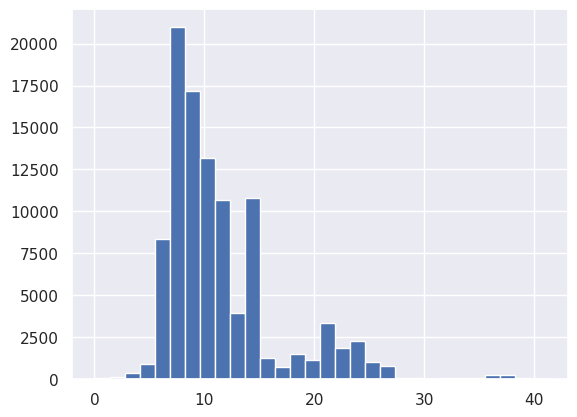

In [59]:
(params_df > 0).sum(axis=1).hist(bins=30)

### Draw embeddings

In [4]:
cols = ["item", "category", "node"]
df_cat_features = pl.scan_parquet(f'{DATA_DIR}/cat_features.pq', low_memory=True).select(cols)

In [5]:
df_cat = df_cat_features.collect().to_pandas()

In [8]:
df_cat = df_cat.set_index('item')

In [9]:
df_text_features = pl.scan_parquet(f'{DATA_DIR}/text_features.pq')

In [10]:
df_text_features.collect().estimated_size('mb')

1555.0248641967773

In [16]:
df_text_features.select(pl.len()).collect().item()

22646691

In [ ]:
# item -> node

In [17]:
df_sample = df_text_features.head(10_000_000).gather_every(10).collect()

In [18]:
df_sample.estimated_size('mb')

68.66455078125

In [19]:
df = df_sample.to_pandas()
df = pd.merge(df_cat, df, on='item', how='right')

In [48]:
def average_embeddings(group):
    return np.mean(np.stack(group['title_projection']), axis=0)

In [51]:
node2proj_df = df.groupby('node').apply(avg_embeddings, include_groups=False).rename('title_projection').reset_index()

In [20]:
del df_sample
del df_cat

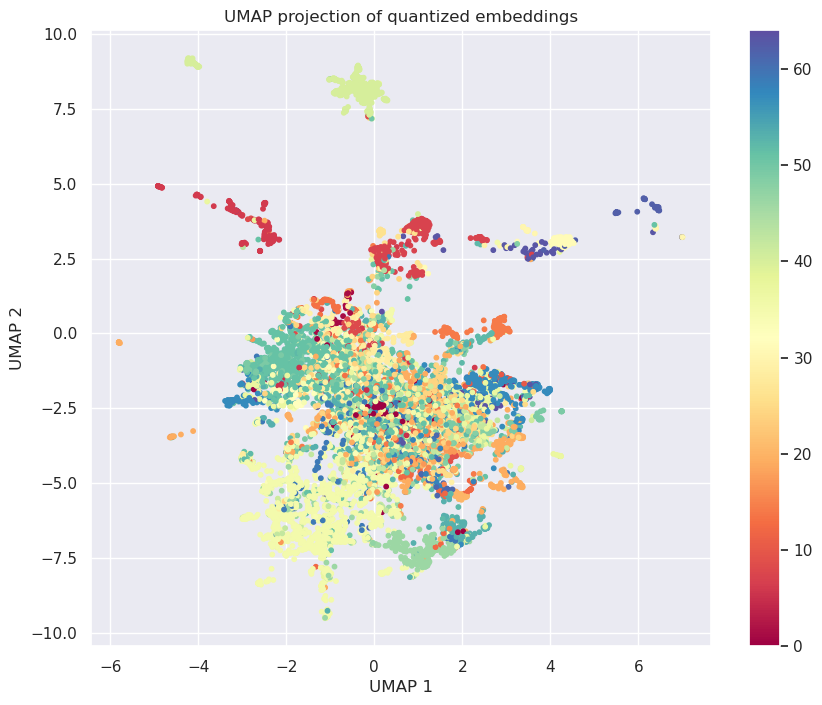

In [63]:
tmp = df.sample(10000)
X = np.vstack(tmp['title_projection'].values)

reducer = umap.UMAP(random_state=42, n_jobs=1)
embedding_umap = reducer.fit_transform(X)

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], s=10, cmap='Spectral', c=tmp['category'])
plt.title('UMAP projection of quantized embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar()
plt.show()

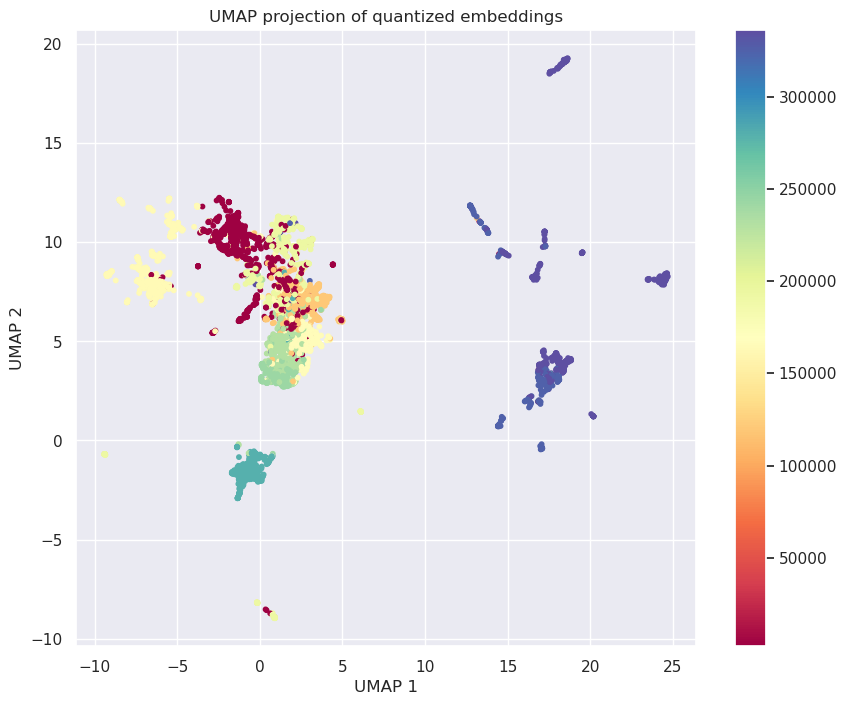

In [95]:
nodes= df.node.value_counts()[10:100].reset_index()['node'].sample(10)
tmp = df[df.node.isin(nodes)]
tmp = tmp.sample(min(tmp.shape[0], 5000))

X = np.vstack(tmp['title_projection'].values)

reducer = umap.UMAP(random_state=42, n_jobs=1)
embedding_umap = reducer.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], s=10, cmap='Spectral', c=tmp['node'])
plt.title('UMAP projection of quantized embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar()
plt.show()

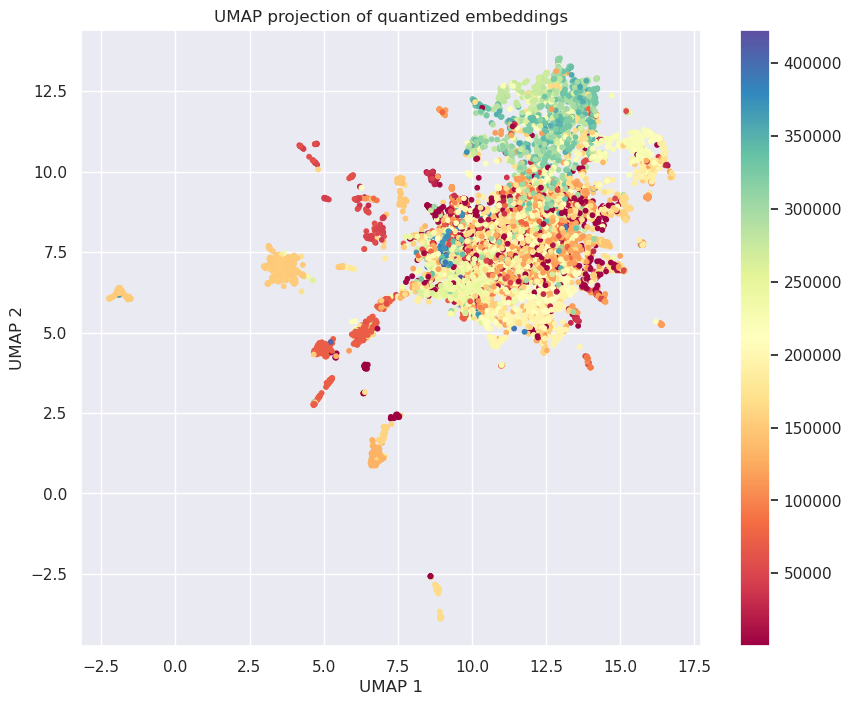

In [62]:
tmp = df.sample(10000)
X = np.vstack(tmp['title_projection'].values)

reducer = umap.UMAP(random_state=42, n_jobs=1)
embedding_umap = reducer.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], s=10, cmap='Spectral', c=tmp['node'])
plt.title('UMAP projection of quantized embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar()
plt.show()

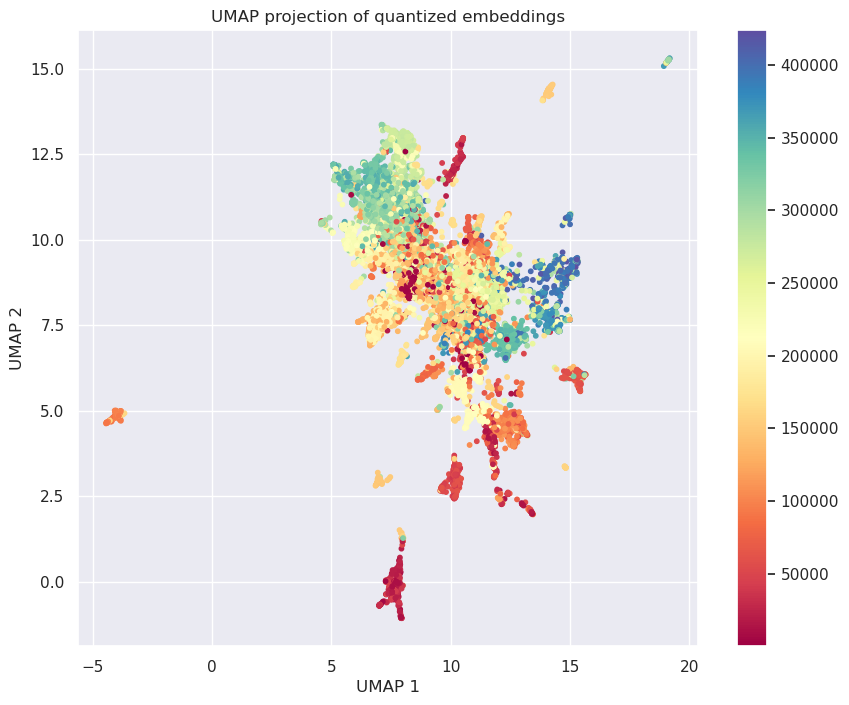

In [61]:
tmp = node2proj_df.sample(10000)
X = np.vstack(tmp['title_projection'].values)

reducer = umap.UMAP(random_state=42, n_jobs=1)
embedding_umap = reducer.fit_transform(X)

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], s=10, cmap='Spectral', c=tmp['node'])
plt.title('UMAP projection of quantized embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar()
plt.show()

### Read clean_params feature

In [4]:
cols = ["clean_params"]
lf = pl.scan_parquet(f'{DATA_DIR}/cat_features.pq').select(cols)

In [5]:
lf.collect().estimated_size('mb')

5930.513085365295

In [6]:
height = lf.select(pl.len()).collect().item()
sample_sz = 10000
x = height // sample_sz
df_sample = lf.head(15_000_000).gather_every(10).collect()

In [7]:
df_sample.estimated_size('mb')

392.3695650100708

In [8]:
df = df_sample.to_pandas()

In [9]:
(df.memory_usage() / 10 ** 6).sum()

12.000128

### Check clean_params dictionary

- each `attr` has multiple `value`'s
- all in all there is 2609 attributes
- `attr`-`value` pair - some discription of an item, so it can be can be treated as word in a text.
- we need to take most popular attr-values to have a mingfull features from them.
- we will take K1 most popular attributes
- Chose of K1= 1900 is baded on distribution of attributes in the corpus.
- and filter values that appers less then 1% times in the attribute

In [112]:
# prepare counts dictioanry of values for each attribute
attr2values = defaultdict(Counter)
attr2total_count = defaultdict(int)


for s in df['clean_params'].values:
    for data in json.loads(s):
        attr = data['attr']
        value = data['value']
        attr2values[attr][value] += 1 # frequency of attr-value in a corpus
        attr2total_count[attr] += 1 # frequency of attr in a corpus

# normalize
for attr in attr2values:
    for val in attr2values[attr]:
        attr2values[attr][val] /= attr2total_count[attr]

In [113]:
df_attr = pd.DataFrame(list(attr2total_count.values()), index= attr2total_count.keys(), columns=['counts'])

In [114]:
df_attr.sort_values('counts', ascending=False)[:K1]

,counts
704,334544
2278,329719
1433,296485
567,244413
1550,244413
...,...
648,102
3841,102
655,102
1046,101


There is 2609 unique attr in corpus.

Distribution of attr counts:
0.1 quantile: 13.0
0.25 quantile: 83.0
0.35 quantile: 186.0
0.5 quantile: 495.0
0.85 quantile: 6339.0
0.95 quantile: 30458.0
max: 334544


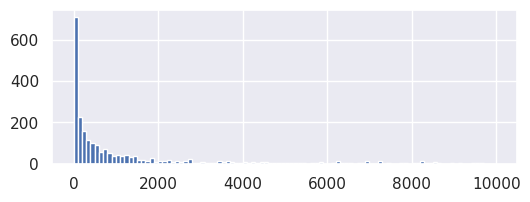

In [115]:
print(f"There is {df_attr.shape[0]} unique attr in corpus.\n")

print("Distribution of attr counts:")
print("0.1 quantile:", df_attr.counts.quantile(.1))
print("0.25 quantile:", df_attr.counts.quantile(.25))
print("0.35 quantile:", df_attr.counts.quantile(.35))
print("0.5 quantile:", df_attr.counts.quantile(.5))
print("0.85 quantile:",  df_attr.counts.quantile(.85).round())
print("0.95 quantile:",  df_attr.counts.quantile(.95).round())
print("max:", df_attr.counts.max())

plt.figure(figsize=(6, 2))
plt.hist(df_attr.counts, bins=100, range=(1, 10_000));

In [116]:
K1 = 1900
most_popular_attrs = df_attr.sort_values('counts', ascending=False)[:K1].index.tolist()

In [117]:
# How many values per attribute?
def get_stats(attr2values):
    counts_per_attr = []
    total_pairs_counts = 0
    for attr in attr2values:
        counts_per_attr.append(len(attr2values[attr])) 
        total_pairs_counts += len(attr2values[attr])
    return counts_per_attr, total_pairs_counts

In [118]:
counts_per_attr, total_pairs_counts = get_stats(attr2values)

There is 137901 unique attr-value pairs in corpus.

Distribution of amount of unique values per attr:
75 percentile: 11.0
85 percentile: 23.0
95 percentile: 113.0
max: 16319


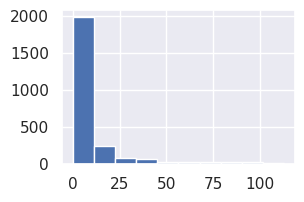

In [119]:
print(f"There is {total_pairs_counts} unique attr-value pairs in corpus.\n")
print("Distribution of amount of unique values per attr:")
print("75 percentile:", np.percentile(counts_per_attr, 75))
print("85 percentile:", np.percentile(counts_per_attr, 85))
print("95 percentile:", np.percentile(counts_per_attr, 95))
print("max:", max(counts_per_attr))

plt.figure(figsize=(3, 2))
plt.hist(counts_per_attr, bins=10, range=(0, 113));

In [120]:
# remove values that appears less then 1%  times in that attr
attr2values_popular = attr2values.copy()
for attr in attr2values_popular:
    to_del = []    
    for val in attr2values_popular[attr]:
        if attr2values_popular[attr][val] < 0.1:
            to_del.append(val)

    for val in to_del:
        del attr2values_popular[attr][val]

In [121]:
# calc unique attr-value pairs if filter non popular attr and non popular values
popular_values_n_attrs_pairs_counts = 0
for attr in attr2values_popular:
    if attr in most_popular_attrs:
        popular_values_n_attrs_pairs_counts += len(attr2values_popular[attr])

In [122]:
counts_per_attr_popular, popular_values_pairs_counts = get_stats(attr2values_popular)

There is 6002 unique attr-value pairs in corpus.

Distribution of amount of unique values per attr:
75 percentile: 3.0
85 percentile: 3.0
95 percentile: 4.0
max: 9


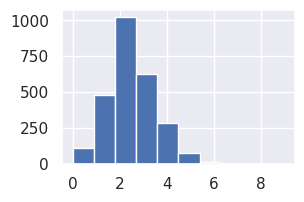

In [123]:
print(f"There is {popular_values_pairs_counts} unique attr-value pairs in corpus.\n")
print("Distribution of amount of unique values per attr:")
print("75 percentile:", np.percentile(counts_per_attr_popular, 75))
print("85 percentile:", np.percentile(counts_per_attr_popular, 85))
print("95 percentile:", np.percentile(counts_per_attr_popular, 95))
print("max:", max(counts_per_attr_popular))

plt.figure(figsize=(3, 2))
plt.hist(counts_per_attr_popular, bins=10,);

In [124]:
print(f"Total unique attr-values pairs in corpus {total_pairs_counts}")
print(f"After removing values with frequency less then 1% in that attr: {popular_values_pairs_counts}")
print(f"After filtering non popular attr: {popular_values_n_attrs_pairs_counts}")

Total unique attr-values pairs in corpus 137901
After removing values with frequency less then 1% in that attr: 6002
After filtering non popular attr: 4325


In [ ]:
# save selected attr-value pairs
attr2values_selected = {}
for a in most_popular_attrs:
    attr2values_selected[a] = list(attr2values_popular[a].keys())

data =json.dumps(attr2values_selected)
with open('models/attr2values_selected.json', 'w') as f:
    json.dump(attr2values_selected, f)

## Click stream

### Basic info with polars

    cookie - id пользователя [int64]
    item - id объявления [int64]
    event - id тип события [int64]. Например “клик”, “показать телефон”, “написать в мессенджер”
    event_date - время, когда пользователь провзаимодействовал с айтемом datetime[ns]
    surface  - экран, с которого было взаимодействие. Например пользователь может взаимодействовать с айтемом на поисковой выдаче, во вкладке “Избранное” [int64]
    platform -  тип устройства, с которого пользователь совершил действие. Например - android, ios, desktop, браузер в телефоне [int64]
    node - id группы товара. Сущность , которую необходимо предсказать [int64]


In [28]:
print(df_clickstream.head(3).collect())

shape: (3, 7)
┌────────┬──────────┬───────┬─────────────────────┬──────────┬─────────┬────────┐
│ cookie ┆ item     ┆ event ┆ event_date          ┆ platform ┆ surface ┆ node   │
│ ---    ┆ ---      ┆ ---   ┆ ---                 ┆ ---      ┆ ---     ┆ ---    │
│ u32    ┆ u32      ┆ u8    ┆ datetime[ns]        ┆ u8       ┆ u8      ┆ u32    │
╞════════╪══════════╪═══════╪═════════════════════╪══════════╪═════════╪════════╡
│ 0      ┆ 19915558 ┆ 17    ┆ 2025-02-05 02:30:59 ┆ 3        ┆ 2       ┆ 115659 │
│ 0      ┆ 2680232  ┆ 17    ┆ 2025-01-24 21:16:57 ┆ 3        ┆ 2       ┆ 115829 │
│ 1      ┆ 4247649  ┆ 17    ┆ 2025-01-29 23:00:58 ┆ 2        ┆ 2       ┆ 7      │
└────────┴──────────┴───────┴─────────────────────┴──────────┴─────────┴────────┘


In [29]:
df_clickstream.describe()

statistic,cookie,item,event,event_date,platform,surface,node
str,f64,f64,f64,str,f64,f64,f64
"""count""",6.8806152e7,6.8806152e7,6.8806152e7,"""68806152""",6.8806152e7,6.8806152e7,6.8806152e7
"""null_count""",0.0,0.0,0.0,"""0""",0.0,0.0,0.0
"""mean""",74884.102841,1.4402e7,16.29883,"""2025-02-01 15:21:43.914605""",2.374055,6.051714,165425.273495
"""std""",43250.599321,8.3145e6,2.188569,null,0.776999,4.695714,88418.121967
"""min""",0.0,0.0,0.0,"""2025-01-10 00:00:00""",0.0,0.0,1.0
"""25%""",37353.0,7.20358e6,17.0,"""2025-01-21 16:02:41""",2.0,2.0,116118.0
"""50%""",74884.0,1.440721e7,17.0,"""2025-02-01 23:37:08""",2.0,3.0,153937.0
"""75%""",112113.0,2.1605283e7,17.0,"""2025-02-12 16:12:00""",3.0,11.0,214338.0
"""max""",149999.0,2.8804867e7,19.0,"""2025-02-23 00:00:00""",6.0,18.0,424068.0


In [37]:
data = {
    "cookie": 134294,
    "item": 22646691,
    "node": 408474,
    "event": 19,
    "platform": 7,
    "surface": 19,
}
pd.DataFrame(data, index=['num unique'])

,cookie,item,node,event,platform,surface
num unique,134294,22646691,408474,19,7,19


### Plots with pandas

In [55]:
df_sample = df_clickstream.gather_every(1000).collect().to_pandas()

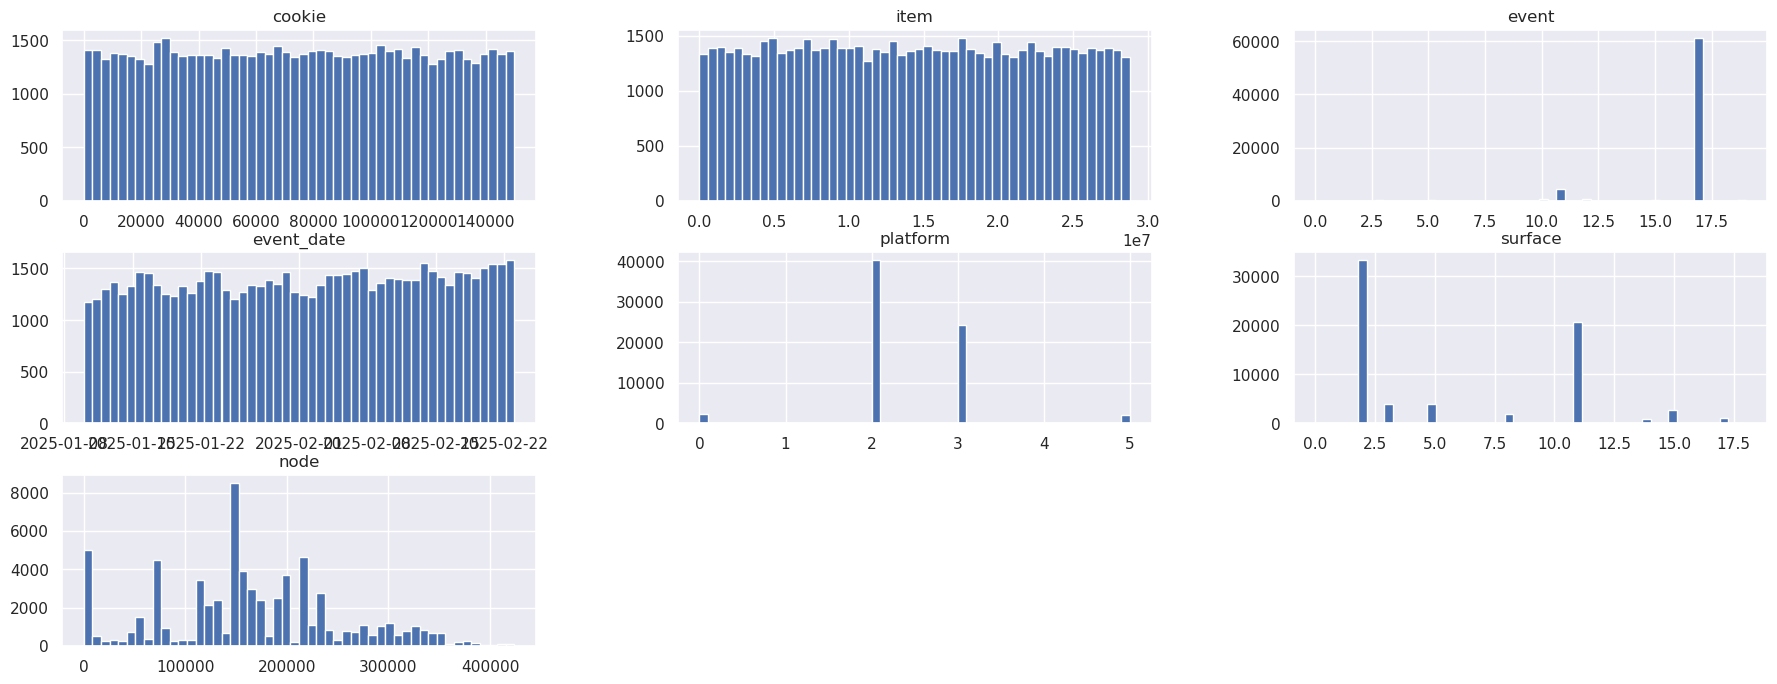

In [58]:
df_sample.hist(figsize=(22, 8), layout=(-1, 3), bins=50);


Равномерное распределение у cookie, item (пользователи и обявления)

У распределения event_date наблюдается сезонность (+-25%), примерно приближенно к равномерному.

In [ ]:
df_sample = df_clickstream.gather_every(1000).collect().to_pandas()

In [61]:
corr = df_sample.corr(numeric_only=True).round(2)
corr.style.background_gradient(cmap='RdYlGn')

,cookie,item,event,platform,surface,node
cookie,1.000000,0.010000,-0.000000,-0.010000,0.000000,-0.010000
item,0.010000,1.000000,0.000000,0.010000,-0.010000,0.010000
event,-0.000000,0.000000,1.000000,-0.010000,-0.040000,-0.010000
platform,-0.010000,0.010000,-0.010000,1.000000,0.030000,0.030000
surface,0.000000,-0.010000,-0.040000,0.030000,1.000000,0.020000
node,-0.010000,0.010000,-0.010000,0.030000,0.020000,1.000000


#### Совместные распределения

In [102]:
pd.crosstab(
    df_sample['platform'],
    df_sample['surface'],
    # normalize=True,
    # margins=True,

).style.background_gradient(cmap='RdYlGn', axis=None, low=0.1)

surface,0,1,2,3,4,5,6,7,8,9,10,11,13,14,15,17,18
platform,,,,,,,,,,,,,,,,,
0,0,0,746,134,1,132,0,0,62,0,6,1027,3,36,153,0,0
1,0,0,0,0,0,1,0,0,0,0,0,5,0,0,1,0,0
2,0,2,21139,2214,45,2142,0,33,1097,7,44,10576,36,409,1666,858,4
3,0,2,10781,1603,28,1415,0,8,723,6,17,8246,13,464,810,163,0
4,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
5,12,3,530,79,0,258,43,0,76,0,1,819,0,54,72,0,0


Совместное распределение платформы и экрана.

In [103]:
pd.crosstab(
    df_sample['platform'],
    df_sample['event'],
    # normalize=True
).style.background_gradient(cmap='RdYlGn', axis=None,)

event,0,2,3,4,5,8,9,10,11,12,13,14,15,16,17,19
platform,,,,,,,,,,,,,,,,
0,0,0,21,6,28,3,1,29,136,16,5,4,10,4,2031,6
1,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0
2,5,3,175,79,148,87,0,447,2558,308,67,23,182,55,36032,103
3,3,6,105,49,82,56,0,319,1495,518,36,20,99,41,21382,68
4,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
5,0,1,18,3,36,4,0,40,130,0,2,0,13,3,1691,6


У платформы 1,4 почти нет событий.

Большинство событий - это тип 17, на платформе 2 или 3.

In [105]:
pd.crosstab(
    df_sample['surface'],
    df_sample['event'],
    # normalize=True
).style.background_gradient(cmap='RdYlGn', axis=None)

event,0,2,3,4,5,8,9,10,11,12,13,14,15,16,17,19
surface,,,,,,,,,,,,,,,,
0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,8,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,0
2,0,2,62,49,59,17,0,260,2228,297,35,3,60,12,30091,21
3,2,1,61,6,40,21,0,111,14,115,13,2,56,17,3539,32
4,0,0,1,0,0,0,0,0,1,1,0,0,0,0,71,0
5,2,0,68,10,44,49,0,80,98,98,11,30,57,38,3295,70
6,0,0,1,0,0,0,0,0,2,0,0,0,2,0,38,0
7,0,0,0,0,0,0,0,0,0,2,0,0,1,0,38,0
8,0,0,18,2,8,18,0,26,124,15,10,1,24,10,1684,18


Самое популярное событие - 17, потом 11. Возможно 17 - это клик, 11 - добавить в избранное.

А 10, 12 - "написать в месенджер" или "посмотреть телефон".

In [108]:
df_sample['event'].value_counts()[:5]

event
17    61136
11     4319
12      842
10      837
3       319
Name: count, dtype: int64

In [107]:
pd.crosstab(
    df_sample[~df_sample['event'].isin([17, 11])]['surface'],
    df_sample[~df_sample['event'].isin([17, 11])]['event'],
    # normalize=True
).style.background_gradient(cmap='RdYlGn', axis=None)

event,0,2,3,4,5,8,9,10,12,13,14,15,16,19
surface,,,,,,,,,,,,,,
0,0,0,1,0,1,0,0,1,0,0,0,1,0,0
2,0,2,62,49,59,17,0,260,297,35,3,60,12,21
3,2,1,61,6,40,21,0,111,115,13,2,56,17,32
4,0,0,1,0,0,0,0,0,1,0,0,0,0,0
5,2,0,68,10,44,49,0,80,98,11,30,57,38,70
6,0,0,1,0,0,0,0,0,0,0,0,2,0,0
7,0,0,0,0,0,0,0,0,2,0,0,1,0,0
8,0,0,18,2,8,18,0,26,15,10,1,24,10,18
11,1,6,100,67,120,41,1,314,238,35,10,92,23,35


Здесь убрали 11, 17 ивент, для удобства просмотра менее популярных типов событий.

В целом, интересных патеррнов не обнаруженно. 

Для всех типов событий самая популярный экран (`surface`) - 2,3,5,11.

#### Проверка типа `event`

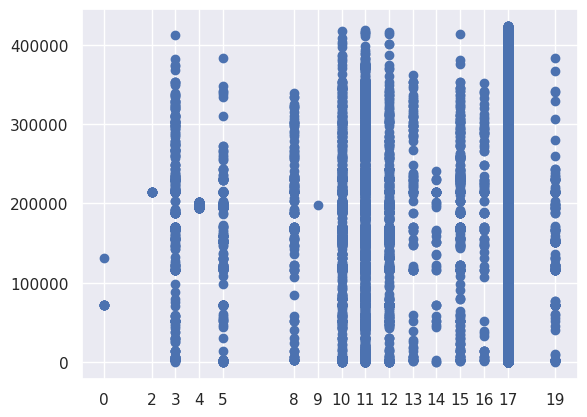

In [131]:
plt.scatter(df_sample.event, df_sample.node);
plt.xticks(df_sample.event.unique(), rotation =0) ;

Какие-то собтия характерны только для очень маленького кол-ва группы товаров.

Также и какие-то экраны характерны только для некоторых групп товаров.

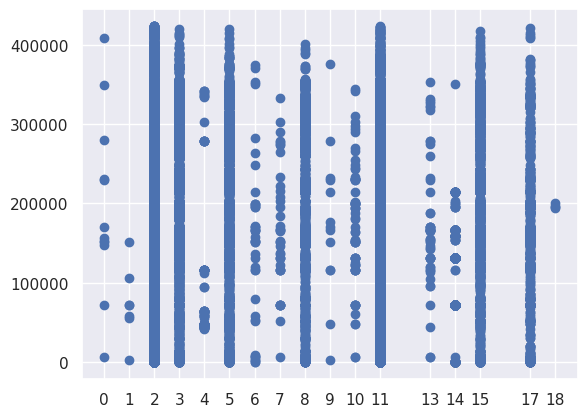

In [121]:
plt.scatter(df_sample.surface, df_sample.node);
plt.xticks(df_sample.surface.unique(), rotation =0) ;

In [123]:
df_sample[df_sample.surface.isin([2,3 ,5, 8, 11, 15, 17])].node.unique().shape

(16546,)

In [124]:
df_sample[~df_sample.surface.isin([2,3 ,5, 8, 11, 15, 17])].node.unique().shape

(355,)

In [127]:
df_event = df_event.to_pandas()

In [132]:
df_event = df_event.set_index('event').sort_index()

In [135]:
df_event[df_event.is_contact==1]

,is_contact
event,
0,1
1,1
2,1
4,1
5,1
6,1
9,1
10,1
13,1


In [141]:
df_sample = df_sample.merge(df_event, on='event')

In [143]:
df_sample.is_contact.mean() * 100

2.8165738950978825

Update предположений:

    17 - просмотр [0]
    11 - клик [0]
    12 - добавить в избранное [0]
    10 - добавить в корзину [1]
    3 -  купить с доставкой [0]
    15 - совершить звонок [1]
    5 - написать сообщение [1]

Возможно какие-то из этих редких "положительных" событий лучше будет объединить при обучении:

        19    0.265961
        4     0.209281
        13    0.159867
        14    0.068307
        2     0.014533
        0     0.011627
        9     0.001453

In [152]:
df_sample[df_sample.is_contact == 1]['event'].value_counts() / df_sample.shape[0] * 100

event
10    1.216446
15    0.441816
5     0.427282
19    0.265961
4     0.209281
13    0.159867
14    0.068307
2     0.014533
0     0.011627
9     0.001453
Name: count, dtype: float64

In [138]:
df_sample['event'].value_counts() / df_sample.shape[0] * 100

event
17    88.851425
11     6.276978
12     1.223713
10     1.216446
3      0.463616
15     0.441816
5      0.427282
19     0.265961
8      0.218001
4      0.209281
13     0.159867
16     0.149694
14     0.068307
2      0.014533
0      0.011627
9      0.001453
Name: count, dtype: float64

#### Проверка событий растянутых по времени

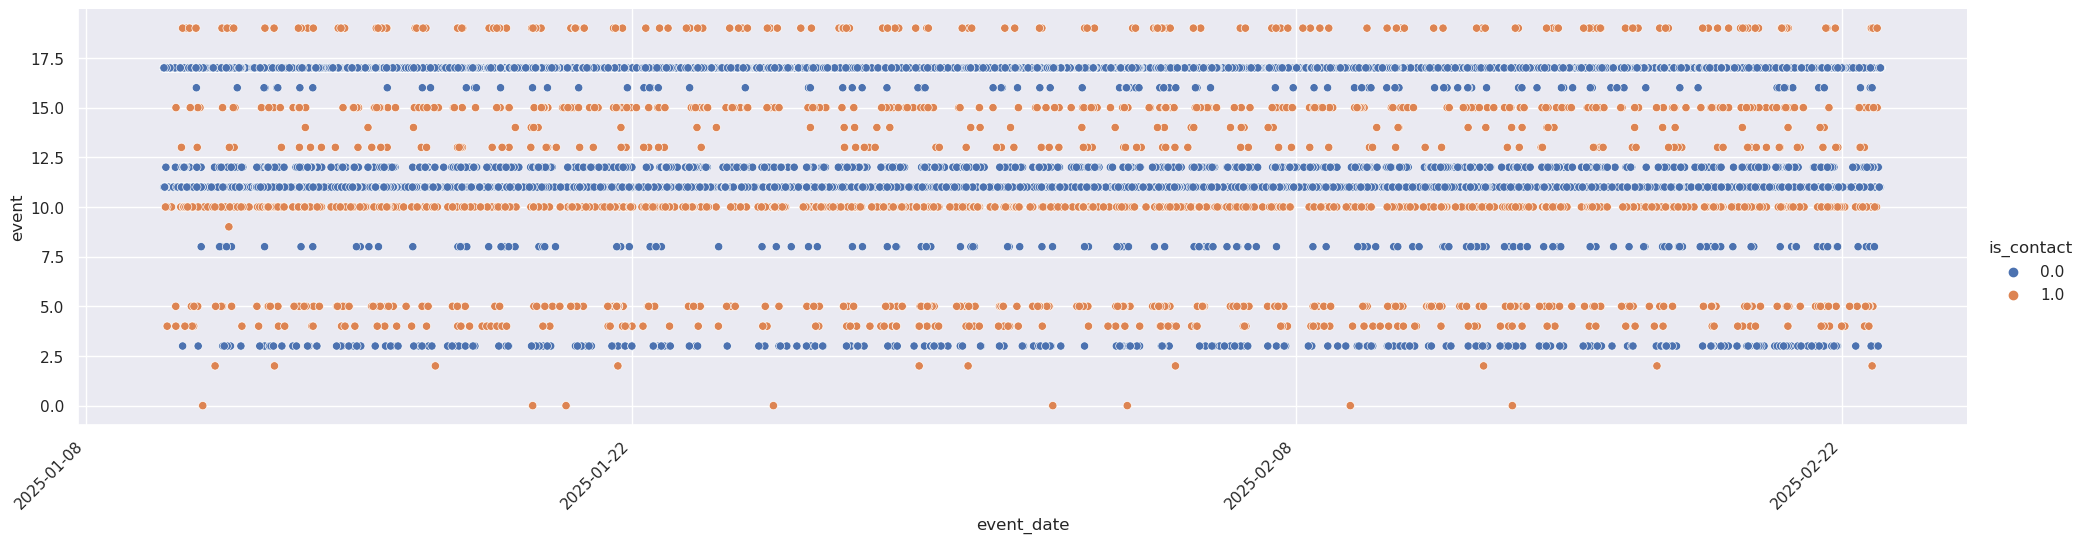

In [168]:
g = sns.relplot(
    data=df_sample,
    x='event_date',
    y='event',
    # kind='line',
    hue='is_contact',
    aspect=4
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

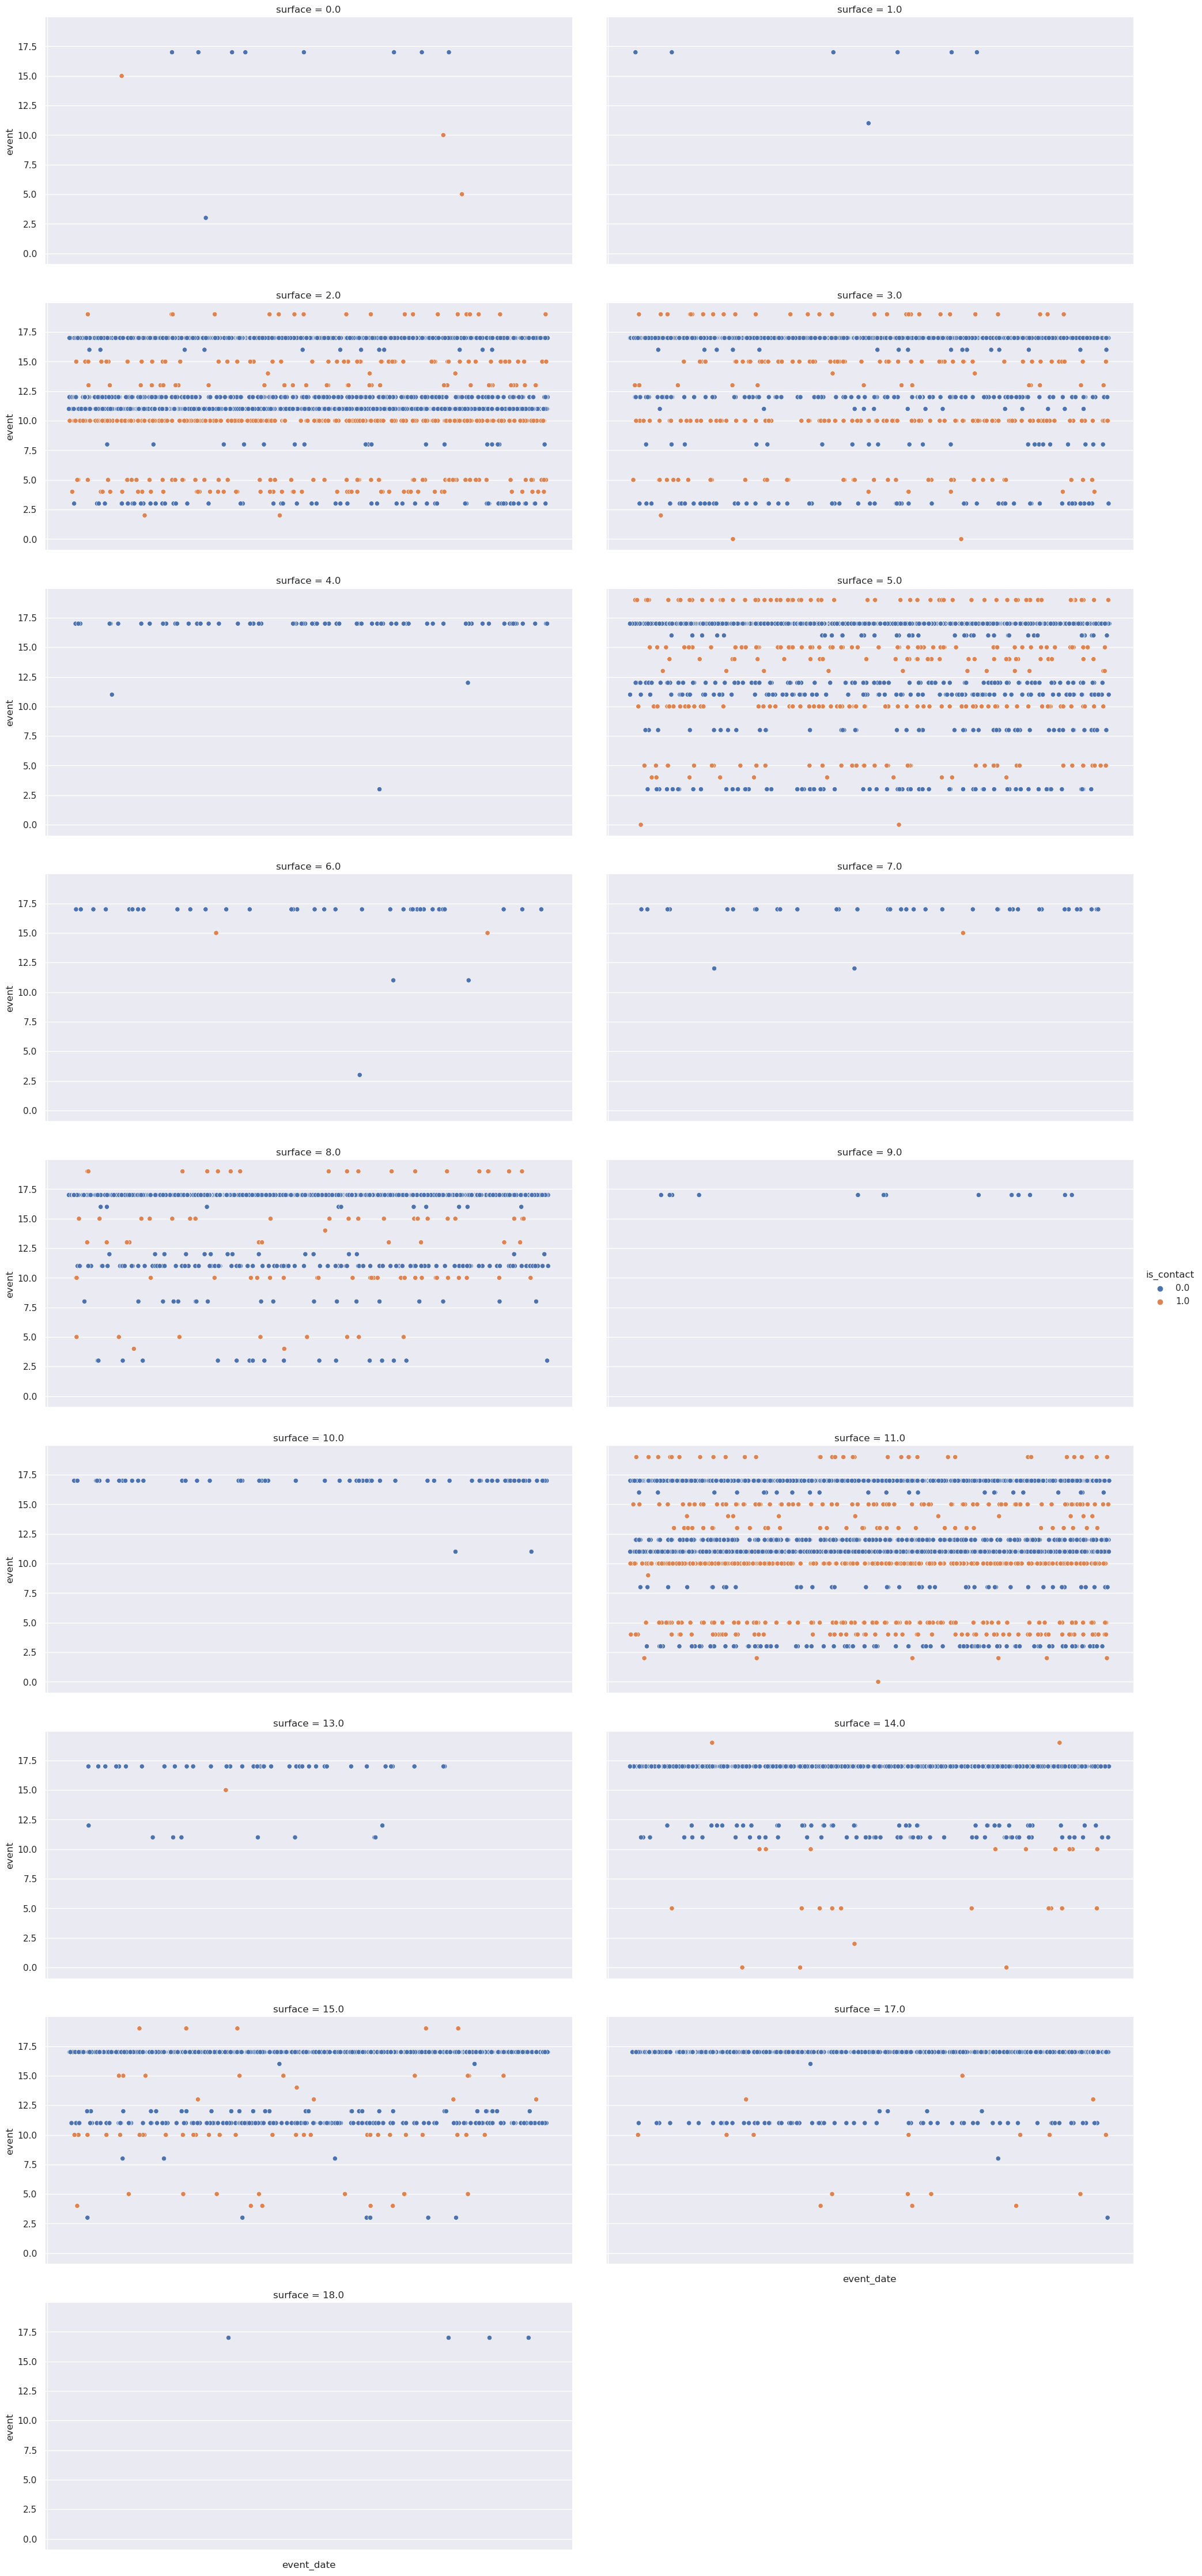

In [200]:
g = sns.relplot(
    data=df_sample,
    x='event_date',
    y='event',
    # kind='line',
    col="surface",
    hue='is_contact',
    aspect=2,
    col_wrap=2
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

In [189]:
users = df_sample.cookie.value_counts().index[5: 15]
tmp  =df_sample[df_sample.cookie.isin(users)]

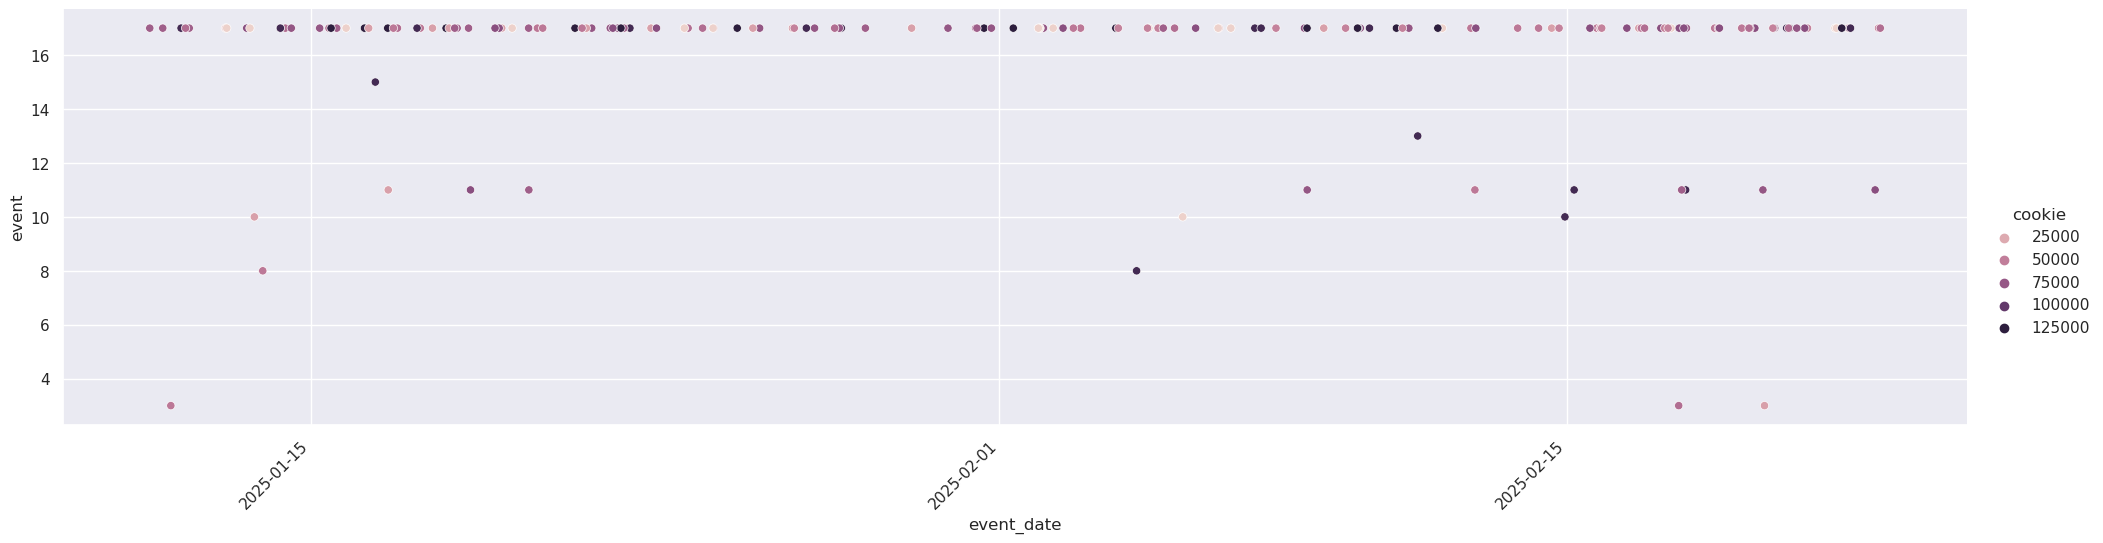

In [190]:
g = sns.relplot(
    data=tmp,
    x='event_date',
    y='event',
    # kind='line',
    hue='cookie',
    aspect=4
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);